Purpose of this notebook:

1. Enable quick manual segmentation of large TIF images containing multiple tiles in x-y and multiple z-planes, in a single channel
2. Create a table of cells X ROIs also containing information about the location of the cell in vivo (within a particular FOV)
3. Allow each cell to have ROIs in multiple z planes
4. Work with single image stitched in x-y if possible
5. Use ROIs from one channel to calculate intensity in other channels and produce histogram

# Setup

In [19]:
!conda install ipykernel --name py365

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.4.6
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base conda




In [4]:
!python -m ipykernel install

Installed kernelspec python3 in C:\ProgramData\jupyter\kernels\python3


In [1]:
%gui qt5 

In [144]:
# Imports in alphabetical order of module name

from PIL import Image, ImageDraw
import napari
import numpy as np
import pickle as pkl
import matplotlib.path as mpltpath
import matplotlib.pyplot as plt
import scipy


# Load images

In [7]:
## Specify images to load

folder = 'Z:\\STVoltron\\454816\\HCR\\S1_dapi_647_525_594_z-stack_tiles_2019_09_04__00_34_59'
base_filename = 'S1_dapi_647_525_594_z-stack_tiles_2019_09_04__00_34_59_z'
plane_nos = range(1, 38)
n = len(plane_nos)
print('Number of planes: {0}'.format(n))

Number of planes: 37


In [119]:
im_array_tac2 = np.zeros([n, h, w, c])

In [120]:
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c1+2+3+4.tif'.format(folder, base_filename,str(p).zfill(2)))
    try:
        full_im = np.array(img)
        im_array_tac2[i, :, :] = np.reshape(full_im[:, :, 0], [h, w, 1])
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18
Loading image 19
Loading image 20
Loading image 21
Loading image 22
Loading image 23
Loading image 24
Loading image 25
Loading image 26
Loading image 27
Loading image 28
Loading image 29
Loading image 30
Loading image 31
Loading image 32
Loading image 33
Loading image 34
Loading image 35
Loading image 36
Loading image 37


In [135]:
im_array_egln3 = np.zeros([n, h, w, c])
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c1+2+3+4.tif'.format(folder, base_filename,str(p).zfill(2)))
    try:
        full_im = np.array(img)
        im_array_egln3[i, :, :] = np.reshape(full_im[:, :, 2], [h, w, 1])
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_egln3 = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18
Loading image 19
Loading image 20
Loading image 21
Loading image 22
Loading image 23
Loading image 24
Loading image 25
Loading image 26
Loading image 27
Loading image 28
Loading image 29
Loading image 30
Loading image 31
Loading image 32
Loading image 33
Loading image 34
Loading image 35
Loading image 36
Loading image 37


In [24]:
# Create 4D array to store images
img = Image.open('{0}\{1}{2}c1+2+3+4.tif'.format(folder, base_filename, str(plane_nos[0]).zfill(2)))
h = img.height
w = img.width
# c = np.array(img).shape[2]
c = 1
im_array = np.zeros([n, h, w, c])
print('Size of image in pixels: {0} X {1} X {2}'.format(n, h, w))

for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c1+2+3+4.tif'.format(folder, base_filename,str(p).zfill(2)))
    try:
        full_im = np.array(img)
        im_array[i, :, :] = np.reshape(full_im[:, :, 1], [h, w, 1])
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue


Size of image in pixels: 37 X 5580 X 5580
Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18
Loading image 19
Loading image 20
Loading image 21
Loading image 22
Loading image 23
Loading image 24
Loading image 25
Loading image 26
Loading image 27
Loading image 28
Loading image 29
Loading image 30
Loading image 31
Loading image 32
Loading image 33
Loading image 34
Loading image 35
Loading image 36
Loading image 37


# Annotation

## Data structure to store information about cells

In [33]:
class Cell:
    n_cells = 1
    
    def __init__(self, cell_no):
        
        self.cell_no = cell_no
        self.z_planes = []
        self.no_planes = 0
        self.masks = {}
        self.c_vals = np.zeros(c)
        print('Cell #{0} created'.format(Cell.n_cells))
        Cell.n_cells += 1
        
    def add_mask(self, z_plane, mask):
        self.z_planes.append(z_plane)
        self.no_planes += 1
        self.masks[z_plane] = mask
            
    def save_cell(self):
        cell_data[self.cell_no] = {'cell_id': self.cell_no,
                                 'z_planes': self.z_planes,
                                 'masks': self.masks,
                                 'no_planes': self.no_planes,
                                 'c_vals':self.c_vals}
    
    def del_cell(self):
        Cell.n_cells -= 1

In [34]:
save_loc = 'Z:\\STVoltron\\454816\\HCR\\'
save_file = 'S1_ex_vivo_segmentation.pkl'
cell_data = {}

## Render image in napari GUI

In [27]:
# Open image in napari viewer - each channel as a separate layer 
viewer = napari.Viewer()

for i in range(c):
    viewer.add_image(im_array[:, :, :, i], name = 'Channel {0}'.format(i + 1), colormap = 'viridis', 
                     interpolation = 'nearest')
    
seg_channel = 0
viewer.add_shapes([], name = 'masks', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)

# Keybinding functions

@viewer.bind_key('n')
def new_cell(viewer):
    global cell1 
    cell1 = Cell(Cell.n_cells)

@viewer.bind_key('m')
def add_mask(viewer):
    seg_layer = viewer.layers[seg_channel]
    z_plane = seg_layer.coordinates[0]
    mask = viewer.layers['masks'].data[-1]
    cell1.add_mask(Cell.n_cells, z_plane, mask)
    
@viewer.bind_key('s')
def save_cell(viewer):
    cell1.save_cell()

C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])


## Manual segmentation

In [35]:
Cell.n_cells

1

In [117]:
if Cell.n_cells > 1:
    cell1.save_cell()
    print('Cell {0} saved'.format(cell1.cell_no))
cell1 = Cell(Cell.n_cells)

Cell 22 saved
Cell #23 created


In [116]:
seg_layer = viewer.layers[seg_channel]
z_plane = seg_layer.coordinates[0]

mask = viewer.layers['masks'].data[-1]
cell1.add_mask(z_plane, mask)
print('mask {0} added in z-plane {1} for cell {2}'.format(cell1.no_planes, z_plane, cell1.cell_no))
print(mask[0, :])

mask 2 added in z-plane 24 for cell 22
[3205.90801103 3382.54698794]


In [179]:
with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
    pkl.dump(cell_data, f)

In [54]:
cell_data

{1: {'cell_id': 1,
  'z_planes': [0, 1],
  'masks': {0: array([[2953.8554176 ,  169.42836987],
          [2951.05161622,  180.02050843],
          [2957.28228596,  187.80884561],
          [2963.82448919,  188.1203791 ],
          [2968.4974915 ,  184.69351074],
          [2970.67822591,  180.02050843],
          [2966.93982406,  174.41290567],
          [2962.26682176,  170.05143685]]),
   1: array([[2949.1824153 ,  169.73990336],
          [2949.1824153 ,  178.15130751],
          [2951.05161622,  184.38197725],
          [2956.65921899,  187.49731212],
          [2960.70915432,  187.80884561],
          [2964.75908965,  187.80884561],
          [2966.62829058,  185.31657771],
          [2968.80902498,  180.95510889],
          [2966.93982406,  175.65903961],
          [2962.57835524,  173.16677172],
          [2956.97075248,  169.73990336]])},
  'no_planes': 2,
  'c_vals': array([0., 0., 0.])},
 2: {'cell_id': 2,
  'z_planes': [0],
  'masks': {0: array([[2858.52617056,  122.38681332

In [342]:
Cell.n_cells = 88

In [341]:
cell_data.pop(88)

{'cell_id': 88,
 'z_planes': [1],
 'masks': {1: array([[ 535.58260252, 5701.99759088],
         [ 537.50285737, 5710.83076323],
         [ 540.57526515, 5716.20747683],
         [ 545.56792778, 5718.12773169],
         [ 549.79248847, 5716.5915278 ],
         [ 551.32869235, 5714.28722197],
         [ 551.32869235, 5708.91050837],
         [ 550.17653944, 5704.30189671],
         [ 547.87223361, 5700.84543797],
         [ 542.49552   , 5697.38897922],
         [ 539.8071632 , 5697.00492825]])},
 'no_planes': 1,
 'c_vals': array([0., 0., 0.])}

In [343]:
cell1 = Cell(88)

Cell #88 created


In [213]:
Cell.n_cells

55

In [57]:
cell1.cell_no

3

In [212]:
len(cell_data.keys())

53

In [448]:
cell1.masks

{12: array([[ 348.29958235, 2505.0680144 ],
        [ 339.20836198, 2506.69144661],
        [ 335.31212468, 2514.48392121],
        [ 337.90961622, 2519.35421784],
        [ 341.48116707, 2522.9257687 ],
        [ 346.02677726, 2524.22451446],
        [ 348.62426879, 2522.27639581],
        [ 350.57238744, 2519.0295314 ],
        [ 352.19581965, 2515.78266698],
        [ 352.84519254, 2508.63956526]]),
 13: array([[ 348.29958235, 2505.0680144 ],
        [ 339.20836198, 2506.69144661],
        [ 335.31212468, 2514.48392121],
        [ 337.90961622, 2519.35421784],
        [ 341.48116707, 2522.9257687 ],
        [ 346.02677726, 2524.22451446],
        [ 348.62426879, 2522.27639581],
        [ 350.57238744, 2519.0295314 ],
        [ 352.19581965, 2515.78266698],
        [ 352.84519254, 2508.63956526]])}

## Calculate intensity in other channels

In [123]:
# Only run once:
xv = range(w)
yv = range(h)
coord_array = np.array(np.meshgrid(xv, yv))

points = np.zeros([h*w, 2])
p = 0
for i in range(h):
    for j in range(w):
        points[p, 1] = coord_array[0, i, j]
        points[p, 0] = coord_array[1, i, j]
        p += 1
        
dil_mask = np.zeros([h, w])

In [166]:
no_cells = len(cell_data.keys())
tac2_avg_intensity = np.zeros(no_cells)
egln3_avg_intensity = np.zeros(no_cells)

for cell in range(no_cells):
    
#     if np.mod(cell, 10) == 0:
    print('Cell {0}'.format(cell))
    cell_no = cell + 1
    cell_dict = cell_data[cell_no]
    masks = cell_dict['masks']
    z_planes = cell_dict['z_planes']

    tac2_intensity = np.zeros(cell_dict['no_planes'])
    egln3_intensity = np.zeros(cell_dict['no_planes'])
    
    i = 0
    for plane in z_planes:

        vertices = masks[plane]
        path = mpltpath.Path(vertices)
        mask = path.contains_points(points)
        mask = np.reshape(mask, [h, w])

        tac2_intensity[i] = np.mean(im_array_tac2[plane, mask, 0])
        egln3_intensity[i] = np.mean(im_array_egln3[plane, mask, 0])
        
        # Background subtraction
        left = np.min(vertices[:, 0])
        right = np.max(vertices[:, 0])
        top = np.min(vertices[:, 1])
        bottom = np.max(vertices[:, 1])
        dil_mask[int(top) - 50:int(bottom) + 50, int(left) - 50:int(right) + 50] = 1
        dil_mask = dil_mask.astype(bool)
        
        tac2_bg = np.mean(im_array_tac2[plane, dil_mask, 0])
        egln3_bg = np.mean(im_array_egln3[plane, dil_mask, 0])
        
        tac2_intensity[i] -= tac2_bg
        egln3_intensity[i] -= egln3_bg
        
        i += 1
    
    tac2_avg_intensity[cell] = np.mean(tac2_intensity)
    egln3_avg_intensity[cell] = np.mean(egln3_intensity)


Cell 0
Cell 1
Cell 2
Cell 3
Cell 4
Cell 5
Cell 6
Cell 7
Cell 8
Cell 9
Cell 10
Cell 11
Cell 12
Cell 13
Cell 14
Cell 15
Cell 16
Cell 17
Cell 18
Cell 19
Cell 20
Cell 21


(array([2., 2., 5., 5., 2., 1., 3., 1., 0., 1.]),
 array([-0.06447348,  0.04197387,  0.14842122,  0.25486857,  0.36131591,
         0.46776326,  0.57421061,  0.68065796,  0.7871053 ,  0.89355265,
         1.        ]),
 <a list of 10 Patch objects>)

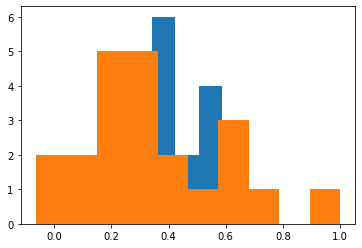

In [167]:
plt.hist(tac2_avg_intensity/np.max(tac2_avg_intensity), 10)
plt.hist(egln3_avg_intensity/np.max(egln3_avg_intensity), 10)

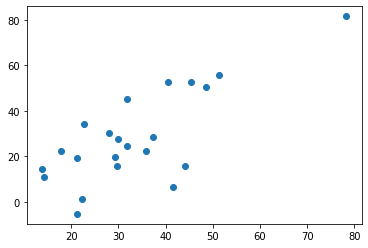

In [168]:
plt.scatter(tac2_avg_intensity, egln3_avg_intensity)

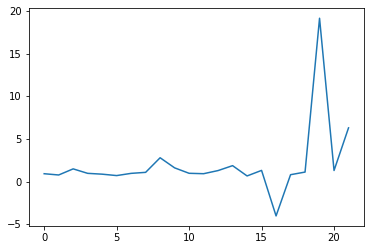

In [169]:
plt.plot(tac2_avg_intensity/egln3_avg_intensity)

In [170]:
fr = [2.6900,    5.2300,    5.9700,    0.3000,    4.5500,   
      10.4100,    1.3100,    3.6900,    2.1600,    2.4100,    2.3000,   
      2.6000,    2.1500,    4.8400,    2.1400,

    2.1100,    2.3500,    1.4700,    4.4300,    2.3700,    2.5600,    3.7900]

In [171]:
ratio = tac2_avg_intensity/egln3_avg_intensity

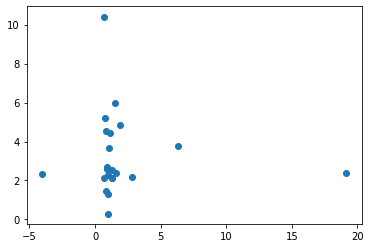

In [172]:
plt.scatter(ratio, fr)

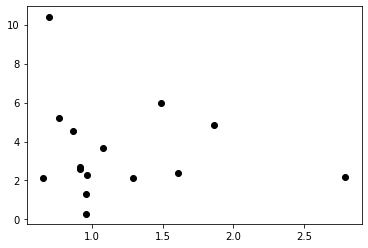

In [178]:
plt.scatter(ratio[:15], fr[:15], color = 'k')
plt.savefig('C:\\Users\\singha\\Documents\\Janelia admin stuff\\2019_hopkins_poster\\spike_rate.svg')